# Clustering : DBSCAN

[Density Based Spatial Clustering of Applications with Noise](https://en.wikipedia.org/wiki/DBSCAN) 
(DBSCAN) is a density-based unsupervised clustering algorithm. 
Given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). 

In [1]:
import torch
torch.manual_seed(42);
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

## Create data (synthetic)
To generate our data, we pick 6 random points, `centroids`.
For each point we're going to generate n_sample random points about it.

In [2]:
n_clusters=6

In [3]:
n_samples=[250,300,75,125,500,400] # this is needed to have clusters of different size
assert n_clusters==len(n_samples)
centroids = torch.randint(-35, 35, (n_clusters, 2)).float()

In [4]:
def sample(m,n_samples): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

slices,labels = zip(*[(sample(c,s),torch.tensor([label]*s)) for label,(c,s) in enumerate(zip(centroids,n_samples))])
tdata = torch.cat(slices)
labels = torch.cat(labels)
tdata.shape, labels.shape

(torch.Size([1650, 2]), torch.Size([1650]))

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

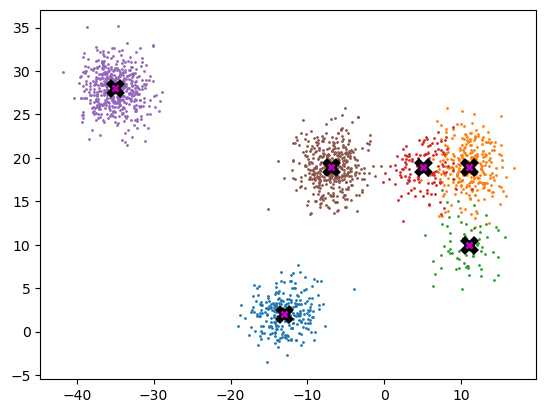

In [5]:
import matplotlib.pyplot as plt

def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i,(c,s) in enumerate(zip(centroids,labels.unique())):
        samples = data[labels==s]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*c, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*c, markersize=5, marker="x", color='m', mew=2)

plot_data(centroids, tdata, labels)

## DBSCAN Algorithm
In DBSCAN, clusters are formed from dense regions and separated by regions of no or low densities.
<br>
Consider a set of points in some space to be clustered. Let ε be a parameter specifying the radius of a neighborhood with respect to some point. 
For the purpose of DBSCAN clustering, the points are classified as core points, (directly-) reachable points and outliers, as follows:
- A point p is a **core point** if at least minPts points are within distance ε of it (including p).
- A point q is **directly reachable** from p if point q is within distance ε from core point p. Points are only said to be directly reachable from core points.
- A point q is **reachable from p** if there is a path $p_1, ..., p_n$ with $p_1 = p$ and $p_n = q$, where each $p_{i+1}$    is directly reachable from $p_i$. Note that this implies that the initial point and all points on the path must be core points, with the possible exception of $q$.
- All points not reachable from any other point are **outliers or noise points.**

Slightly different nomenclature:
- A data point is called a **border point** if it is within a ε-neighborhood of p and it has fewer than the minimum number of points (minPts) within its ε-neighborhood.<br>
- A point that is not a core point nor border point is a **Noise point (Outlier)**.<br> 
- A point x is **directly density reachable** from point p if a point p is a core point and x is in p’s ε-neighborhood. 
- A point y is **density reachable** from point p if a point y is directly density reachable to core point x, which is also density reachable to core point p.


STEPS:
- Choose any point p randomly
- Identify all density reachable points from p with ε and minPts parameter
- If p is a core point, create a cluster (with ε and minPts)
- If p is a border point, visit the next point in a dataset
- Continue the algorithm until all points are visited

DBSCAN does not require specifying the number of clusters initially. <br>
However, DBSCAN requires two parameters viz. the **radius of neighborhoods** for a given data point p (eps or ε) <br>
and the minimum number of data points in a given ε-neighborhood to form clusters (minPts).
<br>
The DBSCAN algorithm can be abstracted into the following steps:[4]
* Find the points in the ε (eps) neighborhood of every point, and identify the core points with more than minPts neighbors.
* Find the connected components of core points on the neighbor graph, ignoring all non-core points.
* Assign each non-core point to a nearby cluster if the cluster is an ε (eps) neighbor, otherwise assign it to noise.

In [9]:
X = tdata.clone() # Data
len(X)

1650

In [19]:
def dist(p1, p2): return ((p1-p2)**2).sum()

In [17]:
def regionQuery(D, i, eps):
    """
    Returns list of all points in dataset `D` within distance `eps` of point `P[i]`.
    """
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        # If the distance is below the threshold, add it to the neighbors list.
        if dist(D[i], D[Pn]) < eps: neighbors.append(Pn)
            
    return neighbors

In [23]:
x0 = X[0]; x0

tensor([-13.5551,  -0.7017])

In [20]:
neighbours = regionQuery(X, 0, eps=4)

In [21]:
len(neighbours)

42

In [22]:
neighbours[:8]

[0, 15, 18, 29, 32, 40, 60, 72]

In [25]:
def growCluster(D, labels, P, NeighborPts, C, eps, MinPts):
    """
    Grow a new cluster with label `C` from the seed point `P`.
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster `C` is complete.
   
    Parameters:
      `D`      - The dataset (a list of vectors)
      `labels` - List storing the cluster labels for all dataset points
      `P`      - Index of the seed point for this new cluster
      `NeighborPts` - All of the neighbors of `P`
      `C`      - The label for this new cluster.  
      `eps`    - Threshold distance
      `MinPts` - Minimum required number of neighbors
    """

    labels[P] = C  # Assign the cluster label to the seed point.
    
    # Look at each neighbor Pn of P. 
    # NeighborPts is a FIFO queue of points to search: it will grow as we discover new branch points for the cluster. 
    # The FIFO behavior is accomplished by using a while-loop rather than a for-loop.
    # In NeighborPts, the points are represented by their index in the original dataset D.
    i = 0
    while i < len(NeighborPts):    

        Pn = NeighborPts[i] # Get the next point from the queue.  
       
        # If Pn was labelled NOISE during the seed search, then it's not a branch point 
        # (it doesn't have enough neighbors), so just make it a leaf point of cluster C and move on.
        if labels[Pn] == -1: labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            labels[Pn] = C # Add Pn to cluster C (Assign cluster label C).
            PnNeighborPts = regionQuery(D, Pn, eps) # Find all the neighbors of Pn
                         
            if len(PnNeighborPts) >= MinPts: # If Pn has at least MinPts neighbors, it's a branch point!
                NeighborPts = NeighborPts + PnNeighborPts # Add all of its neighbors to the FIFO queue to be searched.
            # If Pn *doesn't* have enough neighbors, then it's a leaf point.
      
        i += 1        # Advance to the next point in the FIFO queue.
    
    # We've finished growing cluster C!


In [ ]:
def MyDBSCAN(D, eps, MinPts):
    """
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    MyDBSCAN takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    """
 
    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #    -1 - Indicates a noise point
    #     0 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the 
    # cluster growth is all handled by the 'expandCluster' routine.
    
    # For each point P in the Dataset D...
    # ('P' is the index of the datapoint, rather than the datapoint itself.)
    for P in range(0, len(D)):
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == 0):
           continue
        
        # Find all of P's neighboring points.
        NeighborPts = regionQuery(D, P, eps)
      
        # If the number is below MinPts, this point is noise. 
        # This is the only condition under which a point is labeled 
        # NOISE--when it's not a valid seed point. A NOISE point may later 
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to 
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           C += 1
           growCluster(D, labels, P, NeighborPts, C, eps, MinPts)
    
    # All data has been clustered!
    return labels


In [ ]:
edt = (x, X, eps); edt[:8], len(edt)

In [ ]:
import pandas as pd
pdata = pd.DataFrame(X, columns = ["X", "Y"] )

In [ ]:
pdata.head()

Find a point, eg 0, and retrieve the coordinates of a given point

In [ ]:
i= 0
df = pdata
x, y = df.iloc[i]['X'], df.iloc[i]['Y']
x, y

Given a point, get all the points in its `eps` radius

In [ ]:
import numpy as np
eps = 4
temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != i)]
temp

In [ ]:
def check_core_point(eps,minPts, df, index):
    #get points from given index
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    #check available points within radius
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    #check how many points are present within radius
    if len(temp) >= minPts:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)

In [ ]:
def cluster_with_stack(eps, minPts, df):
    
    #initiating cluster number
    C = 1
    #initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0): #run until all points have been visited

        #identifier for first point of a cluster
        first_point = True
        
        #choose a random unvisited point
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: #run until a cluster is complete
            
            #pop current point from stack
            curr_idx = current_stack.pop()
            
            #check if point is core, neighbour or border
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
            
            #dealing with an edge case
            if (isborder & first_point):
                #for first border point, we label it aand its neighbours as noise 
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #label as visited
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #remove point from unvisited list
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
            
            if iscore: #if current point is a core
                first_point = False
                
                clusters.append((curr_idx,C)) #assign to a cluster
                current_stack.update(neigh_indexes) #add neighbours to a stack

            elif isborder: #if current point is a border point
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #if current point is noise
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #increment cluster number
            C+=1
        
    return clusters
            

In [ ]:
#radius of the circle defined as 0.6
eps = 4
#minimum neighbouring points set to 3
minPts = 3

In [ ]:
import numpy as np

In [ ]:
clustered = cluster_with_stack(eps, minPts, data)

In [ ]:
idx , cluster = list(zip(*clustered))

cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

In [ ]:
plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=f"Cluster{clust}")

plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')

In [ ]:
import random

In [ ]:
x = data[random.randint(0, len(X))]  # first point
x

In [ ]:
x.shape, X.shape

In [ ]:
def check_core_point(eps,minPts, df, index):
    #get points from given index
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    #check available points within radius
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    #check how many points are present within radius
    if len(temp) >= minPts:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)

In [ ]:
(x-X)[:8]

In [ ]:
# the distance of x to every point in X
%time dist = torch.sqrt(((x-X)**2).sum(1))
dist[:8]

In [ ]:
dist.shape

In [ ]:
#TODO HW: Rewrite using torch.einsum

%time dist2 = 
dist2[:8]torch.einsum('ij->i',(x-X)**2).sqrt()

In [ ]:
from fastcore.test import test_close
test_close(dist, dist2)

In [ ]:
weight = gaussian(dist, 2.5)
weight

In [ ]:
weight.shape,X.shape

We now want a weighted average
Formally, the weighted mean of a non-empty finite tuple of data $$\left( x_1, x_2, \dots , x_n \right)$$
with corresponding non-negative weight function|weights $$( w_1, w_2, \dots , w_n)$$ is
$$\bar{x} = \frac{ \sum\limits_{i=1}^n w_i x_i}{\sum\limits_{i=1}^n w_i}$$
which expands to:
$$\bar{x} = \frac{w_1 x_1 + w_2 x_2 + \cdots + w_n x_n}{w_1 + w_2 + \cdots + w_n}.$$

Need to add a trailing axis to the weights to be able to multiply

In [ ]:
(weight[:,None]*X)

In [ ]:
(weight[:,None]*X).sum(0)/weight.sum()

Now all together in a single cell for a single update.

In [ ]:
def one_update(X):
    for i, x in enumerate(X):
        #dist = torch.sqrt(((x-X)**2).sum(1))
        dist = torch.einsum('ij->i',(x-X)**2).sqrt()
        #weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [ ]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [ ]:
%time X=meanshift(data)

We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

In [ ]:
plot_data(centroids+2, X, n_samples)

All the computation is happening in the <tt>for</tt> loop, which isn't accelerated by pytorch. Each iteration launches a new cuda kernel, which takes time and slows the algorithm down as a whole. Furthermore, each iteration doesn't have enough processing to do to fill up all of the threads of the GPU. But at least the results are correct...

We should be able to accelerate this algorithm with a GPU.

## Animation

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def do_one(d):
    if not d: return plot_data(centroids+2, X, n_samples, ax=ax)
    one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [ ]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

**Homework:**
implement [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering), [dbscan](https://en.wikipedia.org/wiki/DBSCAN), 
[locality sensitive hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing), 
or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. 
Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super Bonus: Invent a new meanshift algorithm which picks only the closest points to avoid quadratic time.
SB+: Publish it!


In [ ]:
STOP: no GPU

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [ ]:
def dist_b(a,b): return torch.sqrt(((a[None]-b[:,None])**2).sum(2))

In [ ]:
X=torch.rand(8,2)
x=torch.rand(5,2)
dist_b(X, x)

In [ ]:
bs=5
X = data.clone()
x = X[:bs]
weight = gaussian(dist_b(X, x), 2)
weight

In [ ]:
weight.shape,X.shape

In [ ]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

In [ ]:
div = weight.sum(1, keepdim=True)
div.shape

In [ ]:
num/div

In [ ]:
from fastcore.all import chunked

In [ ]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = (weight[...,None]*X[None]).sum(1)
            div = weight.sum(1, keepdim=True)
            X[s] = num/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [ ]:
data = data.cuda()

In [ ]:
X = meanshift(data).cpu()

In [ ]:
%timeit -n 1 X = meanshift(data).cpu()

In [ ]:
plot_data(centroids+2, X, n_samples)